In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
print(df)

        CHK       PWH       PDC       TWH      FGAS      FOIL       QTOT
0     0.540  0.542755  0.211586  0.594760  0.138882  0.861118  32.358228
1     0.540  0.542755  0.211586  0.594760  0.142222  0.857774  32.940225
2     0.894  0.458000  0.222654  0.616555  0.144697  0.855303  48.633042
3     0.894  0.452311  0.222556  0.609029  0.144938  0.855056  48.065657
4     0.894  0.443485  0.221839  0.602488  0.144187  0.855807  47.096656
...     ...       ...       ...       ...       ...       ...        ...
3094  0.534  0.462606  0.215561  0.592627  0.128039  0.826061  28.108285
3095  0.534  0.462854  0.216331  0.589506  0.127935  0.825378  28.119254
3096  0.534  0.463855  0.239411  0.594895  0.127857  0.824711  27.875849
3097  0.415  0.498174  0.234317  0.581882  0.129256  0.833875  18.412828
3098  0.541  0.463279  0.216901  0.592885  0.127476  0.822423  28.678289

[3099 rows x 7 columns]


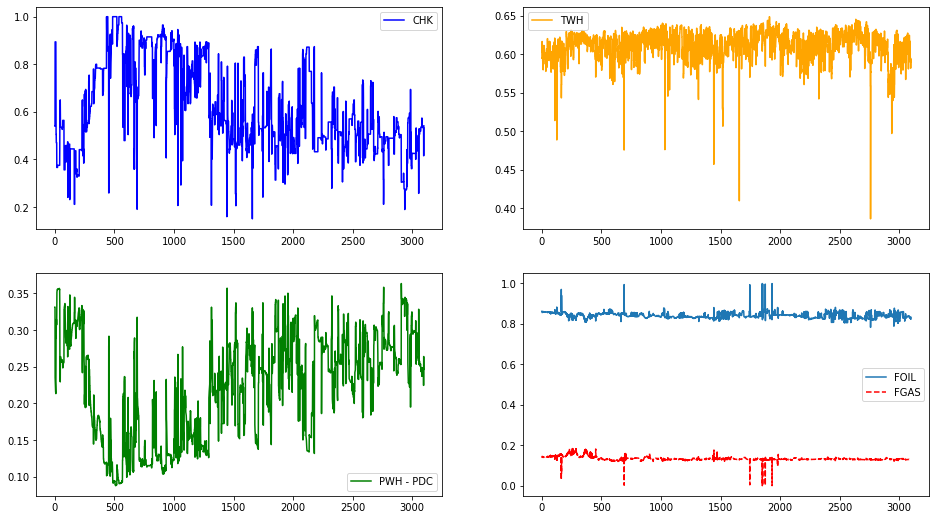

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


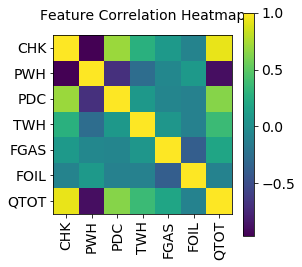

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

# Split into training and test data



In [6]:
test_set = df.iloc[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

train_val_set = df.copy().drop(test_set.index) 


#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train, y_train)


In [7]:
val_set = train_val_set.sample(frac=0.1, replace=False)
train_set = train_val_set.copy().drop(val_set.index)



n_points = len(train_set) + len(val_set) + len(test_set)
print(f'{len(df)} = {len(train_set)} + {len(val_set)} + {len(test_set)} = {n_points}')


x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]


x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]


3099 = 2339 + 260 + 500 = 3099


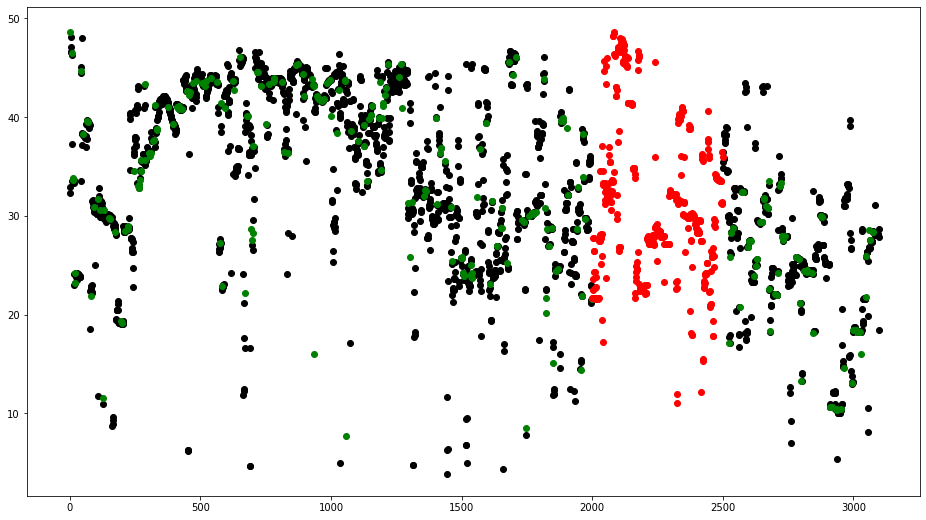

In [8]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')

# Keras Model

In [9]:
from keras import regularizers
from keras.layers import Dropout

input_layer_size = x_train.columns.size

model = keras.Sequential()

model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                350       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 2,993
Trainable params: 2,993
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [12]:

from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10)


model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
234/234 - 0s - loss: 451.1608 - val_loss: 83.0322
Epoch 2/200
234/234 - 0s - loss: 55.1447 - val_loss: 36.0502
Epoch 3/200
234/234 - 0s - loss: 18.1596 - val_loss: 14.9801
Epoch 4/200
234/234 - 0s - loss: 10.4825 - val_loss: 11.4650
Epoch 5/200
234/234 - 0s - loss: 9.1382 - val_loss: 10.6694
Epoch 6/200
234/234 - 0s - loss: 8.4791 - val_loss: 10.4009
Epoch 7/200
234/234 - 0s - loss: 8.1515 - val_loss: 9.2564
Epoch 8/200
234/234 - 0s - loss: 7.8271 - val_loss: 9.0651
Epoch 9/200
234/234 - 0s - loss: 7.6707 - val_loss: 8.6760
Epoch 10/200
234/234 - 0s - loss: 7.5798 - val_loss: 10.0197
Epoch 11/200
234/234 - 0s - loss: 7.4145 - val_loss: 9.1652
Epoch 12/200
234/234 - 0s - loss: 7.0840 - val_loss: 8.1330
Epoch 13/200
234/234 - 0s - loss: 7.1717 - val_loss: 8.1366
Epoch 14/200
234/234 - 0s - loss: 6.8670 - val_loss: 8.5695
Epoch 15/200
234/234 - 0s - loss: 6.8595 - val_loss: 7.9072
Epoch 16/200
234/234 - 0s - loss: 6.7271 - val_loss: 7.9534
Epoch 17/200
234/234 - 0s - loss: 6.6

In [13]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [14]:
## for val

# Pytorch model

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from math import sqrt

%matplotlib inline

class Net(torch.nn.Module):
    """
    PyTorch offers several ways to construct neural networks.
    Here we choose to implement the network as a Module class.
    This gives us full control over the construction and clarifies our intentions.
    """
    
    def __init__(self, layers):
        """
        Constructor of neural network
        :param layers: list of layer widths. Note that len(layers) = network depth + 1 since we incl. the input layer.
        """
        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert len(layers) >= 2, "At least two layers are required (incl. input and output layer)"
        self.layers = layers

        # Fully connected linear layers
        linear_layers = []

        for i in range(len(self.layers) - 1):
            n_in = self.layers[i]
            n_out = self.layers[i+1]
            layer = torch.nn.Linear(n_in, n_out)

            # Initialize weights and biases
            a = 1 if i == 0 else 2
            layer.weight.data = torch.randn((n_out, n_in)) * sqrt(a / n_in)
            layer.bias.data = torch.zeros(n_out)
            
            # Add to list
            linear_layers.append(layer)
        
        # Modules/layers must be registered to enable saving of model
        self.linear_layers = torch.nn.ModuleList(linear_layers)  

        # Non-linearity (e.g. ReLU, ELU, or SELU)
        self.act = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        """
        Forward pass to evaluate network for input values
        :param input: tensor assumed to be of size (batch_size, n_inputs)
        :return: output tensor
        """
        x = input
        for l in self.linear_layers[:-1]:
            x = l(x)
            x = self.act(x)

        output_layer = self.linear_layers[-1]
        return output_layer(x)

    def get_num_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def save(self, path: str):
        """
        Save model state
        :param path: Path to save model state
        :return: None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
        }, path)

    def load(self, path: str):
        """
        Load model state from file
        :param path: Path to saved model state
        :return: None
        """
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.load_state_dict(checkpoint['model_state_dict'])


In [16]:
def train(
        net: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        n_epochs: int,
        lr: float,
        l2_reg: float,
) -> torch.nn.Module:
    """
    Train model using mini-batch SGD
    After each epoch, we evaluate the model on validation data

    :param net: initialized neural network
    :param train_loader: DataLoader containing training set
    :param n_epochs: number of epochs to train
    :param lr: learning rate (default: 0.001)
    :param l2_reg: L2 regularization factor (default: 0)
    :return: torch.nn.Module: trained model.
    """

    # Define loss and optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Train Network
    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            # Zero the parameter gradients (from last iteration)
            optimizer.zero_grad()

            # Forward propagation
            outputs = net(inputs)
            
            # Compute cost function
            batch_mse = criterion(outputs, labels)
            
            reg_loss = 0
            for param in net.parameters():
                reg_loss += param.pow(2).sum()

            cost = batch_mse + l2_reg * reg_loss

            # Backward propagation to compute gradient
            cost.backward()
            
            # Update parameters using gradient
            optimizer.step()
        
        # Evaluate model on validation data
        mse_val = 0
        for inputs, labels in val_loader:
            mse_val += torch.sum(torch.pow(labels - net(inputs), 2)).item()
        mse_val /= len(val_loader.dataset)
        print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')
        
    return net


In [17]:
# Define the target and features
INPUT_COLS = ['CHK', 'PWH', 'PDC', 'TWH', 'FGAS', 'FOIL']
OUTPUT_COLS = ['QTOT']

# Get input and output tensors and convert them to torch tensors
x_train = torch.from_numpy(train_set[INPUT_COLS].values).to(torch.float)
y_train = torch.from_numpy(train_set[OUTPUT_COLS].values).to(torch.float)

x_val = torch.from_numpy(val_set[INPUT_COLS].values).to(torch.float)
y_val = torch.from_numpy(val_set[OUTPUT_COLS].values).to(torch.float)

# Create dataset loaders
# Here we specify the batch size and if the data should be shuffled
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_set), shuffle=False)


In [18]:
layers = [len(INPUT_COLS), 50, 50, len(OUTPUT_COLS)]
net = Net(layers)

print(f'Layers: {layers}')
print(f'Number of model parameters: {net.get_num_parameters()}')
# print(6*50 + 50 + 50*50 + 50 + 50 * 1 + 1)


Layers: [6, 50, 50, 1]
Number of model parameters: 2951


In [19]:
n_epochs = 100
lr = 0.001
l2_reg = 0.001  # 10
net = train(net, train_loader, val_loader, n_epochs, lr, l2_reg)


Epoch: 1: Val MSE: 66.45511568509616
Epoch: 2: Val MSE: 39.09469275841346
Epoch: 3: Val MSE: 15.810430438701923
Epoch: 4: Val MSE: 11.019211989182692
Epoch: 5: Val MSE: 9.663242750901443
Epoch: 6: Val MSE: 8.840877591646635
Epoch: 7: Val MSE: 8.343125563401442
Epoch: 8: Val MSE: 8.028721266526443
Epoch: 9: Val MSE: 7.854271521935096
Epoch: 10: Val MSE: 7.771708327073317
Epoch: 11: Val MSE: 7.580009577824519
Epoch: 12: Val MSE: 7.546005483774039
Epoch: 13: Val MSE: 7.424667123647836
Epoch: 14: Val MSE: 7.3172194260817305
Epoch: 15: Val MSE: 7.875614107572115
Epoch: 16: Val MSE: 7.274293870192308
Epoch: 17: Val MSE: 7.3768531212439905
Epoch: 18: Val MSE: 7.218572528545673
Epoch: 19: Val MSE: 7.032651930588942
Epoch: 20: Val MSE: 6.9935105543870195
Epoch: 21: Val MSE: 6.881447190504808
Epoch: 22: Val MSE: 6.96729971078726
Epoch: 23: Val MSE: 6.839504770132211
Epoch: 24: Val MSE: 6.934135084885817
Epoch: 25: Val MSE: 7.230649977463942
Epoch: 26: Val MSE: 7.229589374248798
Epoch: 27: Val MS

In [20]:
# Predict on validation data
pred_val = net(x_val)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = torch.mean(torch.pow(pred_val - y_val, 2))
print(f'MSE: {mse_val.item()}')

mae_val = torch.mean(torch.abs(pred_val - y_val))
print(f'MAE: {mae_val.item()}')

mape_val = 100*torch.mean(torch.abs(torch.div(pred_val - y_val, y_val)))
print(f'MAPE: {mape_val.item()} %')


Error on validation data
MSE: 4.560179710388184
MAE: 1.3867921829223633
MAPE: 5.431568622589111 %


In [21]:
# Get input and output as torch tensors
x_test = torch.from_numpy(test_set[INPUT_COLS].values).to(torch.float)
y_test = torch.from_numpy(test_set[OUTPUT_COLS].values).to(torch.float)

# Make prediction
pred_test = net(x_test)

# Compute MSE, MAE and MAPE on test data
print('Error on test data')

mse_test = torch.mean(torch.pow(pred_test - y_test, 2))
print(f'MSE: {mse_test.item()}')

mae_test = torch.mean(torch.abs(pred_test - y_test))
print(f'MAE: {mae_test.item()}')

mape_test = 100*torch.mean(torch.abs(torch.div(pred_test - y_test, y_test)))
print(f'MAPE: {mape_test.item()} %')


Error on test data
MSE: 2.5347766876220703
MAE: 1.2314767837524414
MAPE: 3.7076659202575684 %


# Compare

In [22]:
print("Error on test data")
mse_test = np.mean(np.power(keras_predictions - y_test.numpy(), 2))
print("MSE: ", mse_test) #2.6873526

mae_test = np.mean(np.abs(keras_predictions-y_test.numpy()))
print("MAE: ", mae_test) # 1.12

mape_test = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.numpy(), y_test.numpy())))
print("MAPE: ", mape_test, "%") # 3.574





Error on test data
MSE:  2.0585687
MAE:  0.9982965
MAPE:  3.0666740611195564 %


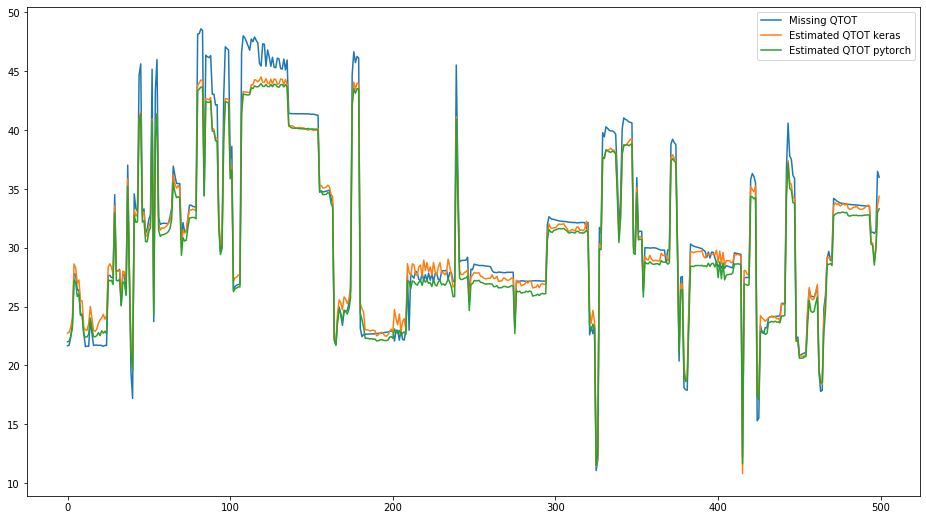

In [23]:
plt.figure(figsize=(16,9))
plt.plot(y_test.numpy(), label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT keras')
plt.plot(pred_test.detach().numpy(), label='Estimated QTOT pytorch')
plt.legend()